In [1]:
import os
thisDir = os.path.abspath(os.curdir)
os.chdir("../")

In [2]:
%matplotlib inline

In [3]:
import gpfanova, runFANOVA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# All data 

In [61]:
x,y,effect,labels= runFANOVA.loadData(heatshock=True,scaleX=False,nanRemove=True,
                                               plates=['heatshock_12'],
                                               #strains=['ura3+pMTFcmyc','VNG1179C+pMTFcmyc','VNG1179C-VNG1179C'])
                                               strains=['ura3','ura3+pMTFcmyc','VNG1179C+pMTFcmyc','VNG1179C-VNG1179C','copR'])
labels

Index([u'ura3+pMTFcmyc', u'VNG1179C+pMTFcmyc', u'VNG1179C-VNG1179C', u'copR',
       u'ura3'],
      dtype='object')

In [63]:
order =[u'ura3',  u'copR', u'ura3+pMTFcmyc', u'VNG1179C+pMTFcmyc', u'VNG1179C-VNG1179C',]
index = map(lambda x: order.index(x),labels)
index

[2, 3, 4, 1, 0]

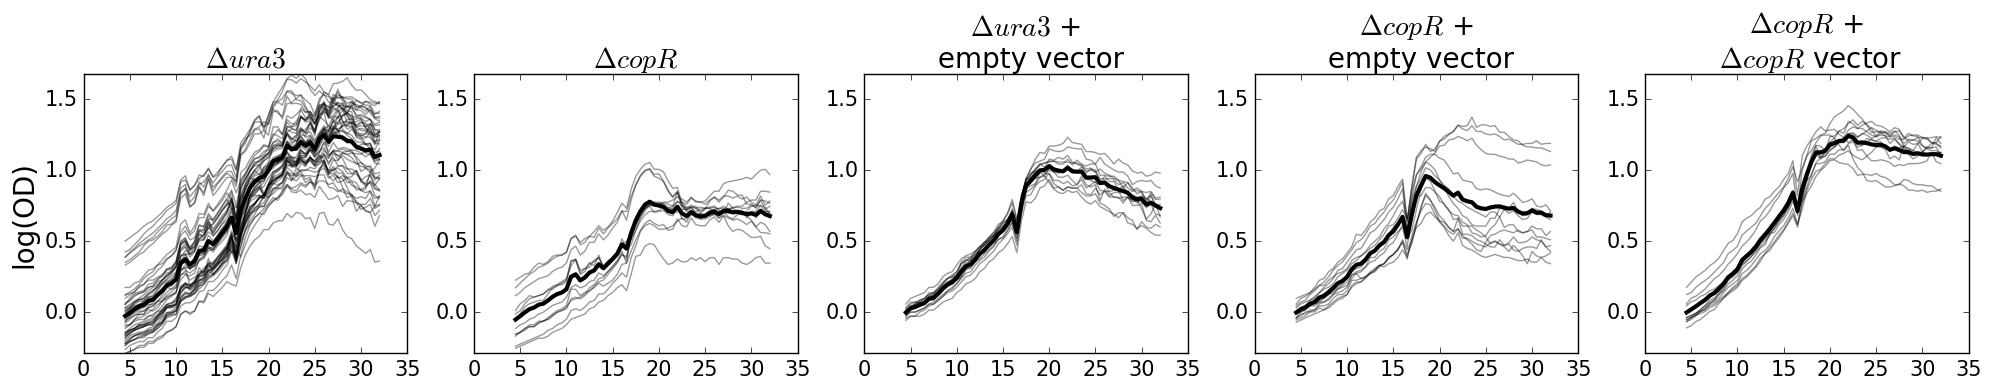

In [69]:
plt.figure(figsize=(20,4))
ncol = len(labels)
for i in range(ncol):
    ii = index[i]
    plt.subplot(1,ncol,ii+1)

    #plt.title(labels[i])
    s = labels[i]
    if 'pMTFcmyc' in s:
        s = s.split("+")
        if s[0] == 'VNG1179C':
            s[0] = 'copR'
        plt.title("$\Delta %s$ +\n empty vector"%s[0],fontsize=20)
    elif '-' in s:
        s = s.split("-")
        if s[0] == 'VNG1179C':
            s[0] = 'copR'
        plt.title("$\Delta %s$ +\n $\Delta copR$ vector"%s[0],fontsize=20)
    else:
        plt.title("$\Delta "+s+"$",fontsize=20)

    select = (effect[:,0]==i)
    plt.plot(x,y[:,select],c='k',lw=1,alpha=.4)
    plt.plot(x,y[:,select].mean(1),c='k',lw=3)
    plt.ylim(y.min(),y.max())
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    if j > 0:
        plt.xlabel("time (h)",fontsize=20)
    if ii == 0:
        plt.ylabel("log(OD)",fontsize=20)
        
plt.tight_layout()
plt.savefig("figures/copr-compliment-data-all.pdf",dpi=300)

In [24]:
neweffects = np.zeros((5,3),dtype=int)
neweffects[labels.str.contains("VNG1179"),0] = 1
neweffects[labels.str.contains("copR"),0] = 1
neweffects[labels.str.contains("\+"),1] = 1
neweffects[labels=='VNG1179C-VNG1179C',[1,2]] = 1
effect = neweffects[effect[:,0],:]

In [7]:
# m = gpfanova.fanova.FANOVA(x,y,effect,interactions=False,helmertConvert=True,parameterFile='results/hsalTF/hsalTF_coprCompliment_helmertConvert__run1.csv')
m = gpfanova.fanova.FANOVA(x,y,effect,interactions=False,helmertConvert=True,parameterFile='results/posteriorSamples_coprCompliment_helmertConvert__run24208171.csv')
# m = gpfanova.fanova.FANOVA(x,y,effect,interactions=False,helmertConvert=True,parameterFile='results/hsalTF/hsalTF_coprCompliment_helmertConvert__run24209088.csv')
# m = gpfanova.fanova.FANOVA(x,y,effect,interactions=False,helmertConvert=True,parameterFile='results/hsalTF/hsalTF_coprCompliment_helmertConvert__run24209455.csv')

In [8]:
m.mk

[2, 2, 2]

In [9]:
m.parameter_history.shape

(487, 737)

In [25]:
# temporary workaround for mismatch in gpfanova versions
# newer version allows for multiple covariates, and assumes a lengthscale for each
# older version (where samples are from) does not

m.parameter_history['prior0_lengthscale0'] = m.parameter_history['prior0_lengthscale']
m.parameter_history['prior1_lengthscale0'] = m.parameter_history['prior1_lengthscale']
m.parameter_history['prior2_lengthscale0'] = m.parameter_history['prior2_lengthscale']
m.parameter_history['prior3_lengthscale0'] = m.parameter_history['prior3_lengthscale']

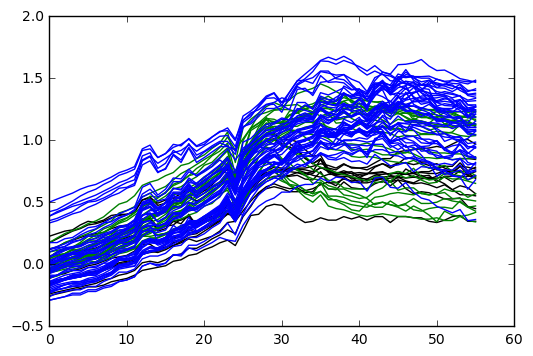

In [11]:
plt.plot(m.y[:,np.all(m.effect[:,[0,1]]==[1,0],1)],'k');
plt.plot(m.y[:,np.all(m.effect[:,[0,1]]==[1,1],1)],'g');
plt.plot(m.y[:,np.all(m.effect[:,[0,1]]==[0,0],1)],'b');

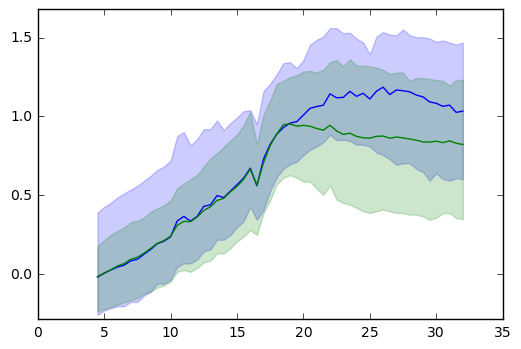

In [12]:
gpfanova.plot.plotSingleEffect(m,0,data=True)

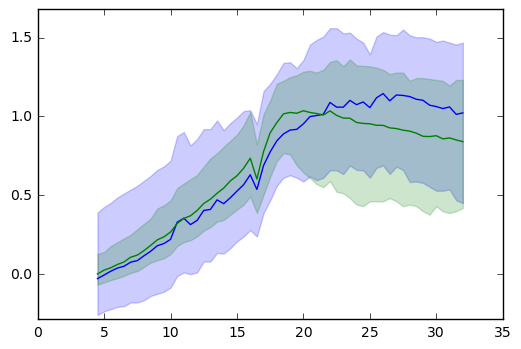

In [13]:
gpfanova.plot.plotSingleEffect(m,1,data=True)

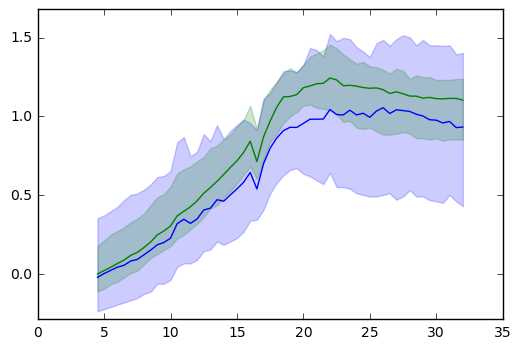

In [14]:
gpfanova.plot.plotSingleEffect(m,2,data=True)

In [15]:
ura3Ind = labels.tolist().index('ura3')
ura3Ind

4

In [16]:
labelsTrim = labels[labels!='ura3']
labelsTrim

Index([u'ura3+pMTFcmyc', u'VNG1179C+pMTFcmyc', u'VNG1179C-VNG1179C', u'copR'], dtype='object')

In [17]:
import matplotlib as mpl
import scipy
from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram

def plot_delta(x,deltas,probability=False,cluster=False,plot_cluster=False,cluster_kwargs={},dendrogram_kwargs={},ytick_filter=lambda x: x):
    p = len(deltas.keys())
    n = x.shape[0]
    a = np.zeros((p,n))
    prob = np.zeros((p,n))
    yticks = [ytick_filter(k) for k in deltas.keys()]
    
    clusterShape=4

    for i,k in enumerate(deltas.keys()):
        samples = deltas[k]
        med = np.median(samples,0)
        samples = np.sort(samples,0)
        ns = samples.shape[0]
        lb,ub = .025*ns,.975*ns
        lb,ub = samples[[lb,ub],:]

        a[i,:] = med
        prob[i,:] = ub*lb>0 # any bounds without matching signs crosses the origin

    if cluster:
        l = linkage(a,**cluster_kwargs)
        ind = leaves_list(l)
        a = a[ind,:]
        prob = prob[ind,:]
        yticks = [yticks[j] for j in ind]
        
        if plot_cluster:
            ax = plt.subplot2grid((1,clusterShape),(0,0),colspan=1,rowspan=1)
            dendrogram(l,no_labels=True,orientation='left',ax=ax,**dendrogram_kwargs)
            ax.set_xticks([])

    lim = np.max(np.abs(a))
    vmin = -lim
    vmax = lim

    if plot_cluster:
        ax = plt.subplot2grid((1,clusterShape),(0,1),colspan=clusterShape-1,rowspan=1)
    else:
        ax = plt.subplot2grid((1,5),(0,0),colspan=4,rowspan=1)
        
    if probability:
        # a[np.abs(prob-.5)<.475] = 0
        a[prob<1] = 0
        
    plt.imshow(a,cmap="RdBu",interpolation="none",vmin=vmin,vmax=vmax,origin='lower',aspect="auto")
    plt.yticks(range(p),yticks)
    i = np.arange(1.*n/4,n,1.*n/4)
    plt.xticks(i,[x[j].round(2) for j in i],fontsize=15)
    plt.xlabel("time (h)",fontsize=20)
    
    if plot_cluster:
#         if probability:
#             cbarAx,kwargs = mpl.colorbar.make_axes(ax)
#             cbar = mpl.colorbar.ColorbarBase(cbarAx,cmap='RdBu',ticks=[0,.5,1],**kwargs)
#             cbar.ax.set_yticklabels(['p(less\n than parent)\n>97.5%', 'no difference', 'p(greater\n than parent)\n>97.5%'],fontsize=15)
#         else:
        plt.colorbar()
    else:
        plt.colorbar()

In [18]:
# m.parameter_cache = m.parameter_history.iloc[-1,:]

In [19]:
# m.sample(3000,10,random=True)
# m.parameter_history.shape

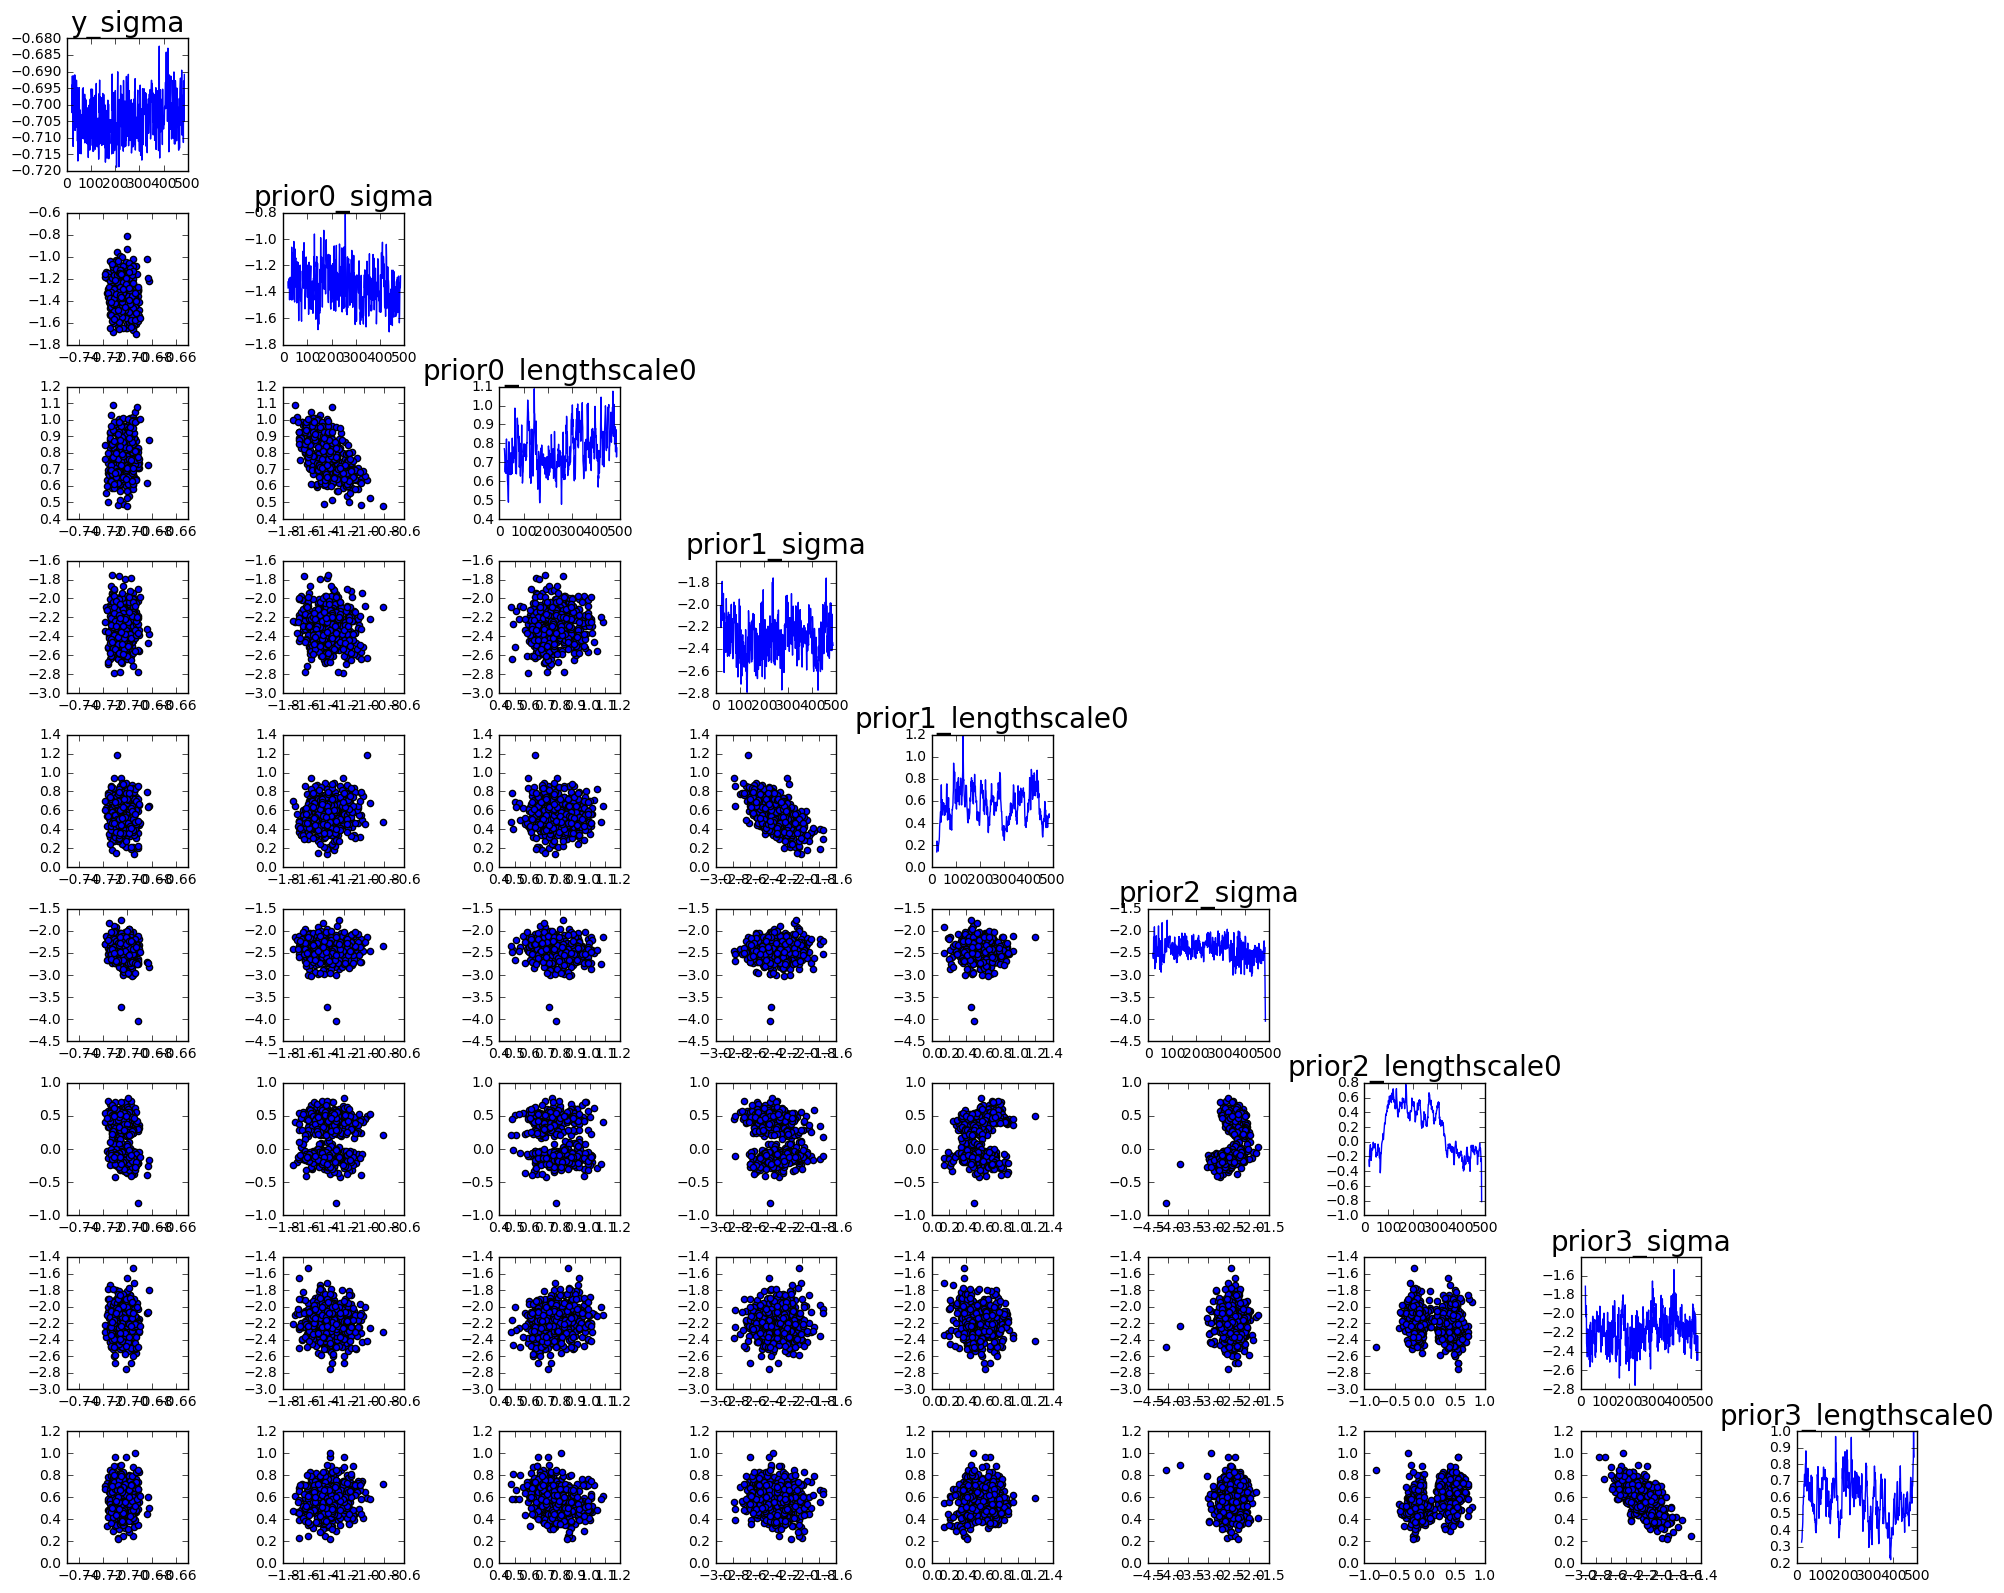

In [26]:
plt.figure(figsize=(20,16))
gpfanova.plot.plotHyperparameters(m,correlative=True,burnin=20)
plt.tight_layout(pad=1)
plt.savefig(os.path.join('figures','copr-hyperparameters.png'),bbox_inches='tight',dpi=300)

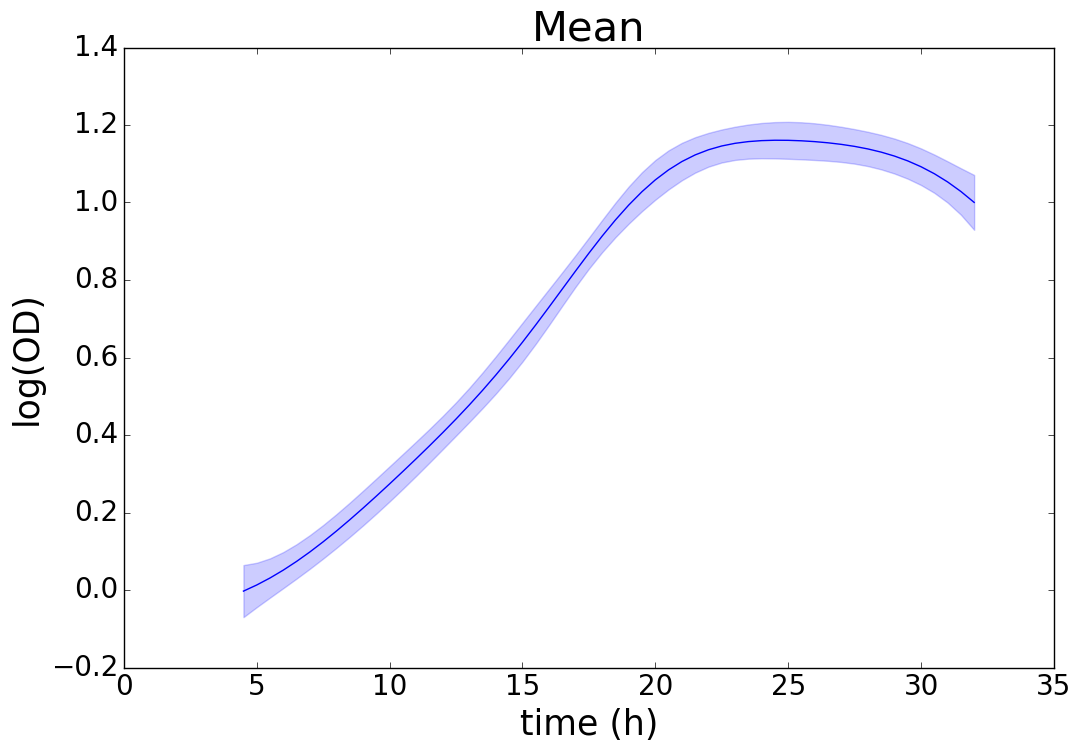

In [28]:
plt.figure(figsize=(12,8))
gpfanova.plot.plotFunctionSamples(m.parameterSamples('mean').values,x=m.x,intervalKwargs={'tol':1e-1},burnin=20)
plt.title("Mean",fontsize=30)
plt.legend(loc='best',fontsize=20)
plt.xlabel("time (h)",fontsize=25)
plt.ylabel("log(OD)",fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig(os.path.join('figures','copr-mean.png'),bbox_inches='tight',dpi=300)

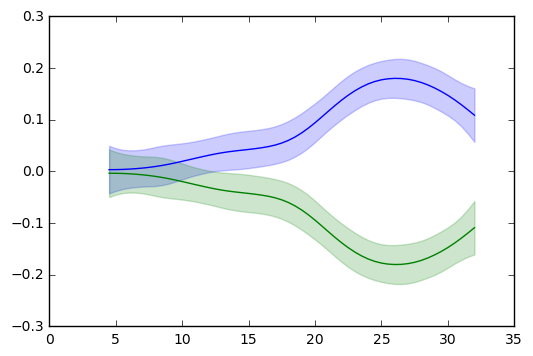

In [29]:
gpfanova.plot.plotSingleEffect(m,0,function=True,burnin=20)

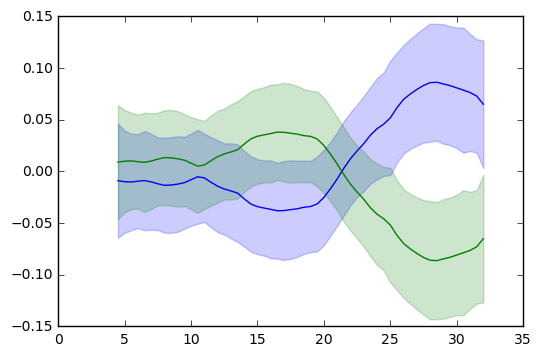

In [30]:
gpfanova.plot.plotSingleEffect(m,1,function=True,burnin=20)

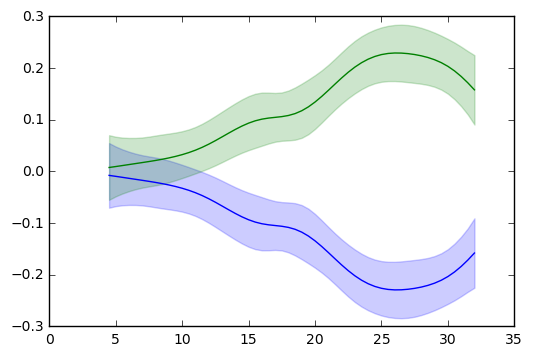

In [31]:
gpfanova.plot.plotSingleEffect(m,2,function=True,burnin=20)

In [32]:
shiftInd = 23

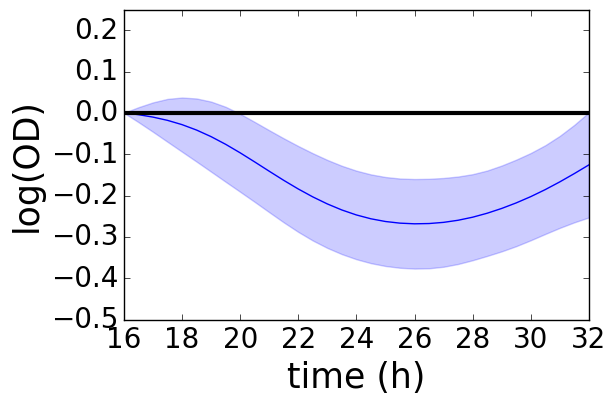

In [33]:
offset = m.parameterSamples('alpha_1').values[:,shiftInd] - m.parameterSamples('alpha_0').values[:,shiftInd]
samples= m.parameterSamples('alpha_1').values[:,shiftInd:] - m.parameterSamples('alpha_0').values[:,shiftInd:] - offset[:,None]
    
gpfanova.plot.plotFunctionSamples(samples,m.x[shiftInd:],burnin=20,intervalKwargs={"tol":1e-2})
plt.plot([m.x[shiftInd:].min(),m.x[shiftInd:].max()],[0,0],'k',lw=3)

plt.xlabel("time (h)",fontsize=25)
plt.ylabel("log(OD)",fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(-.5,.25)
plt.savefig(os.path.join('figures','copr-Control.pdf'),bbox_inches='tight',dpi=300)

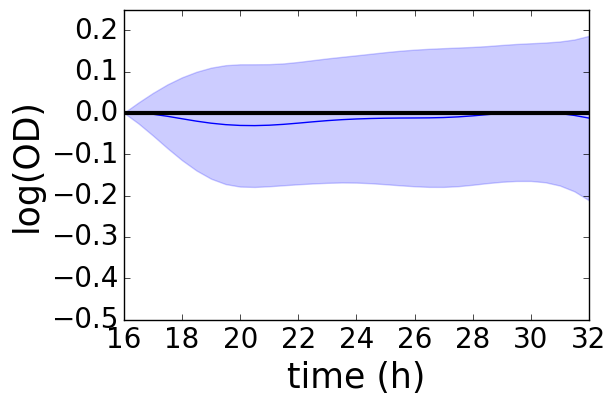

In [34]:
offset = m.parameterSamples('alpha_1').values[:,shiftInd] - m.parameterSamples('alpha_0').values[:,shiftInd] +  m.parameterSamples('gamma_1').values[:,shiftInd] - m.parameterSamples('gamma_0').values[:,shiftInd]
samples= m.parameterSamples('alpha_1').values[:,shiftInd:] - m.parameterSamples('alpha_0').values[:,shiftInd:] +  m.parameterSamples('gamma_1').values[:,shiftInd:] - m.parameterSamples('gamma_0').values[:,shiftInd:] - offset[:,None]
    
gpfanova.plot.plotFunctionSamples(samples,m.x[shiftInd:],burnin=20,intervalKwargs={"tol":1e-2})
plt.plot([m.x[shiftInd:].min(),m.x[shiftInd:].max()],[0,0],'k',lw=3)

plt.xlabel("time (h)",fontsize=25)
plt.ylabel("log(OD)",fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(-.5,.25)
plt.savefig(os.path.join('figures','copr-compliment.pdf'),bbox_inches='tight',dpi=300)

# Only vector 

In [34]:
x,y,effect,labels= runFANOVA.loadData(heatshock=True,scaleX=False,nanRemove=True,
                                               plates=['heatshock_12'],
                                               strains=['ura3+pMTFcmyc','VNG1179C+pMTFcmyc','VNG1179C-VNG1179C'])

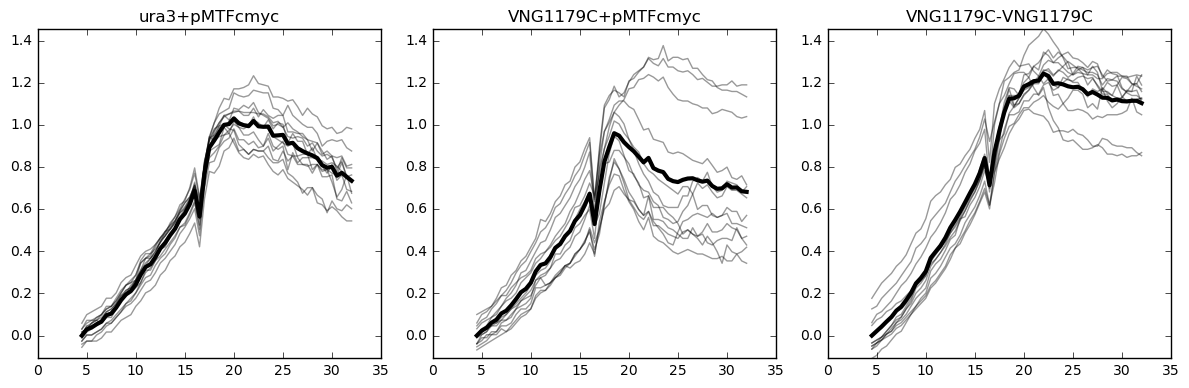

In [35]:
plt.figure(figsize=(12,4))
ncol = len(labels)
for i in range(ncol):
    plt.subplot(1,ncol,i+1)

    plt.title(labels[i])

    select = (effect[:,0]==i)
    plt.plot(x,y[:,select],c='k',lw=1,alpha=.4)
    plt.plot(x,y[:,select].mean(1),c='k',lw=3)
    plt.ylim(y.min(),y.max())
        
plt.tight_layout()
plt.savefig("figures/copr-compliment-data.pdf",dpi=300)

(-0.10847164791899999, 1.45631297086)

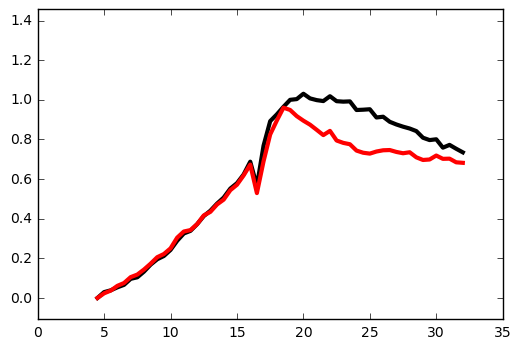

In [36]:
select = (effect[:,0]==0)
plt.plot(x,y[:,select].mean(1),c='k',lw=3)
select = (effect[:,0]==1)
plt.plot(x,y[:,select].mean(1),c='r',lw=3)
plt.ylim(y.min(),y.max())

In [37]:
neweffects = np.zeros((effect.shape[0],2))
neweffects[:,0] = effect[:,0]
neweffects[:,1] = effect[:,0] > 1 # only compliment strain has full vector
neweffects[neweffects[:,0]==2,0] = 1 # reset compliment to just strain (1)

effect = neweffects

effect

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.]])

In [38]:
m = gpfanova.fanova.FANOVA(x,y,effect,interactions=False,helmertConvert=True)

/home/ptonner/dev/hsalinarum_tf_phenotype/local/lib/python2.7/site-packages/gpfanova/fanova.py:298: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x[s,ind:ind+self.mk[i]-1] = self.contrasts[i][self.effect[s,i],:]


In [57]:
m.sample(3000,thin=10)

In [58]:
shiftInd = 23

(-0.5, 0.25)

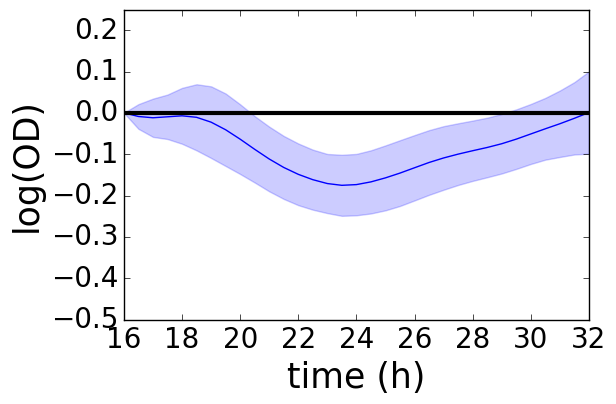

In [59]:
offset = m.parameterSamples('alpha_1').values[:,shiftInd] - m.parameterSamples('alpha_0').values[:,shiftInd]
samples= m.parameterSamples('alpha_1').values[:,shiftInd:] - m.parameterSamples('alpha_0').values[:,shiftInd:]- offset[:,None]
    
gpfanova.plot.plotFunctionSamples(samples,m.x[shiftInd:],burnin=0,intervalKwargs={"tol":1e-2})
plt.plot([m.x[shiftInd:].min(),m.x[shiftInd:].max()],[0,0],'k',lw=3)

plt.xlabel("time (h)",fontsize=25)
plt.ylabel("log(OD)",fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(-.5,.25)
# plt.savefig(os.path.join('figures','copr-Control.pdf'),bbox_inches='tight',dpi=300)

(-0.5, 0.32)

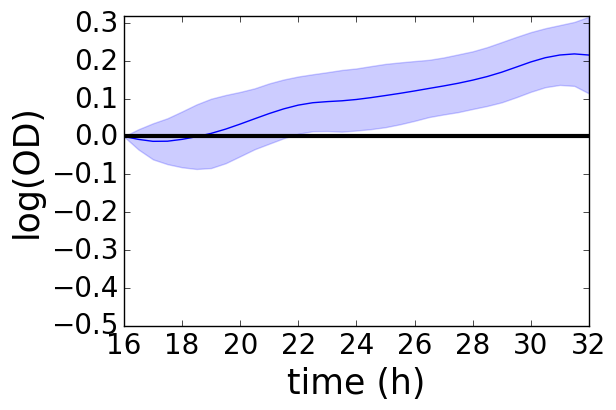

In [60]:
offset = m.parameterSamples('alpha_1').values[:,shiftInd] - m.parameterSamples('alpha_0').values[:,shiftInd] +  m.parameterSamples('beta_1').values[:,shiftInd] - m.parameterSamples('beta_0').values[:,shiftInd]
samples= m.parameterSamples('alpha_1').values[:,shiftInd:] - m.parameterSamples('alpha_0').values[:,shiftInd:] +  m.parameterSamples('beta_1').values[:,shiftInd:] - m.parameterSamples('beta_0').values[:,shiftInd:] - offset[:,None]
    
gpfanova.plot.plotFunctionSamples(samples,m.x[shiftInd:],burnin=0,intervalKwargs={"tol":1e-2})
plt.plot([m.x[shiftInd:].min(),m.x[shiftInd:].max()],[0,0],'k',lw=3)

plt.xlabel("time (h)",fontsize=25)
plt.ylabel("log(OD)",fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(-.5,.32)
# plt.savefig(os.path.join('figures','copr-compliment.pdf'),bbox_inches='tight',dpi=300)